In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import numpy as np
import copy
import time

In [3]:
try:
    from tqdm import tqdm
except:
    !pip install tqdm;
from apafib import load_MNIST
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Binarizer
from sklearn.neighbors import KNeighborsClassifier

# Utils

In [4]:
def show_image(image, n_cols=3, n_rows=1, labels=[4,7,9]):
    plt.figure(figsize=(6,3));
    plt.gray()
    for i, y in zip(range(n_cols*n_rows), labels):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.matshow(image[i].reshape(28,28))
        plt.xticks([]); plt.yticks([]);
        plt.title(str(y));
    plt.show()

In [5]:
def split_list_into_diferent_y(X, Y):
    list_of_4 = [x for x, y in zip(X, Y) if y == 4]
    list_of_7 = [x for x, y in zip(X, Y) if y == 7]
    list_of_9 = [x for x, y in zip(X, Y) if y == 9]
    return list_of_4, list_of_7, list_of_9

In [6]:
def plot_2d_PCA(X, Y, title, vtitle):
  l4, l7, l9 = split_list_into_diferent_y(X, Y)
  colors = ['tab:blue', 'tab:orange', 'tab:green']
  lw = 1
  plt.figure()
  for i, c, l in zip([l4, l7, l9], colors, [4,7,9]):
      plt.scatter(np.array(i)[:,0], np.array(i)[:,1], marker='.', color=c, alpha=1, lw=lw, label=l)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)  
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()

In [7]:
def model_fit_and_score (model, X_train, Y_train, X_test, Y_test, call_show_image=True, return_model=False, return_exec_time=False):
    init_time = time.time()
    model.fit(X_train, Y_train)
    list_of_4_test, list_of_7_test, list_of_9_test = split_list_into_diferent_y(X_test, Y_test)
    iterator_list_of_4_test, iterator_list_of_7_test, iterator_list_of_9_test = iter(list_of_4_test), iter(list_of_7_test), iter(list_of_9_test)
    image_4_test, image_7_test, image_9_test = next(iterator_list_of_4_test), next(iterator_list_of_7_test), next(iterator_list_of_9_test)
    image_4_test_prediction, image_7_test_prediction, image_9_test_prediction = model.predict([image_4_test]), model.predict([image_7_test]), model.predict([image_9_test])
    if call_show_image: show_image([image_4_test, image_7_test, image_9_test], labels=[image_4_test_prediction, image_7_test_prediction, image_9_test_prediction])
    if return_exec_time: return model.score(X_test, Y_test), (time.time() - init_time)
    if return_model: return model, model.score(X_test, Y_test), model.get_params()
    return model.score(X_test, Y_test), model.get_params()

# Dataset Loading and Preprocessing

In [8]:
X_train, X_test, Y_train, Y_test = load_MNIST()

In [9]:
list_of_4, list_of_7, list_of_9 = split_list_into_diferent_y(X_train, Y_train)

In [10]:
iterator_list_of_4 = iter(list_of_4)
iterator_list_of_7 = iter(list_of_7)
iterator_list_of_9 = iter(list_of_9)

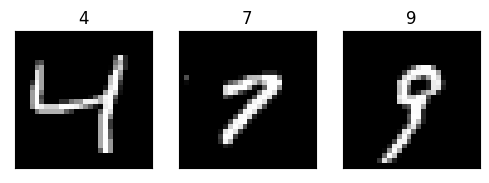

In [11]:
image_4 = next(iterator_list_of_4)
image_7 = next(iterator_list_of_7)
image_9 = next(iterator_list_of_9)
show_image([image_4, image_7, image_9])

# Apartado 1.
Los datos corresponden a imágenes de 28 × 28 píxeles en niveles de gris. Estos ya están convertidos a vectores y normalizados a la escala [0,1]. Aplica PCA a los datos de entrenamiento y represéntalos en 2D. ¿Se puede ver separabilidad entre las clases? Comenta el resulado

Si aplicamos PCA a los datos de entrenamiento y lo representamos en una grafica bidimensional se puede ver que dependiendo del tipo de numero que estamos representado el valor del PCA se situa en una parte u otra. En otras palabras, si nos fijamos en la figura, vemos como los datos que representan el numero 4 se encuentrar, en su gran mayoria, en la parte superior derecha de la representación. Por contra, el numero 7, se encuentra, en su mayoria, en la parte inferior izquierda.

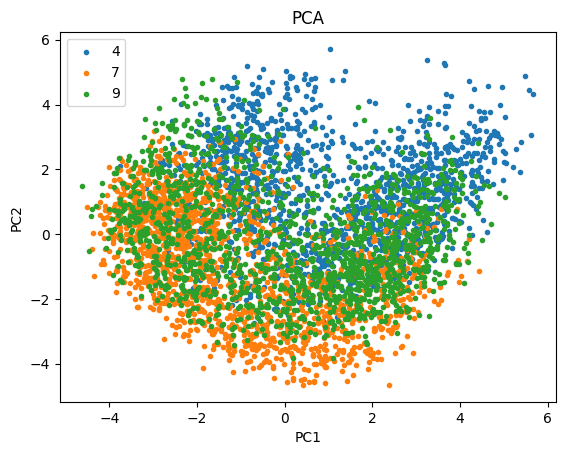

In [12]:
X_train_transformed = PCA().fit_transform(X_train)
plot_2d_PCA(X_train_transformed[:,:2], Y_train, 'PCA', 'PC')

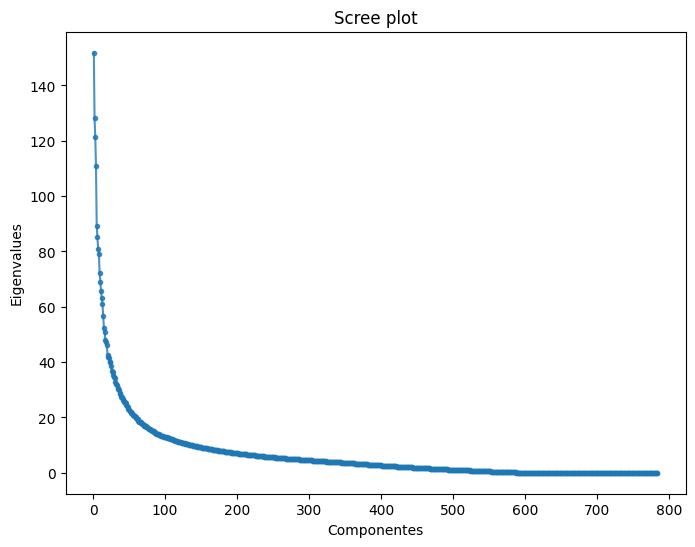

In [13]:
fitted_pca = PCA().fit(X_train)
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(fitted_pca.singular_values_ )+1),fitted_pca.singular_values_ ,alpha=0.8,marker='.')
y_label = plt.ylabel('Eigenvalues')
x_label = plt.xlabel('Componentes')
plt.title('Scree plot');

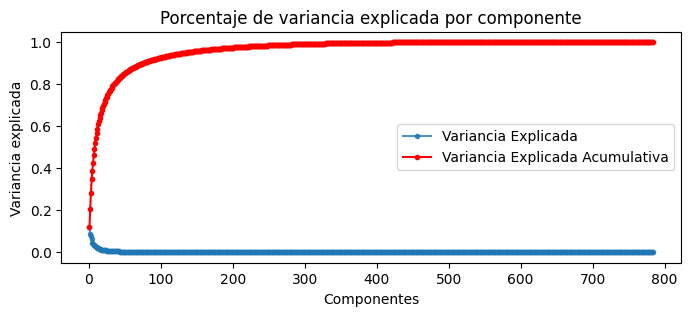

In [14]:
fig = plt.figure(figsize=(8,3));
plt.plot(range(1,len(fitted_pca.explained_variance_ratio_ )+1),fitted_pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(fitted_pca.explained_variance_ratio_ )+1),
         np.cumsum(fitted_pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia Explicada Acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

# Apartado 2.
Asumiendo que los píxeles son independientes y se distribuyen de manera gausiana, ajusta un modelo Naïve Bayes gausiano y evalúa la calidad del modelo. Cuanto más acerquemos los datos a lo que supone el modelo que ajustamos probablemente obtengamos un mejor resultado. Una posibilidad es binarizar la matriz de datos usando un límite de 0.5 y asumir que los píxeles siguen una distribución de Bernoulli. Transforma los datos a binarios utilizando la función Binarizer y ajusta un Naïve Bayes Bernoulli. Evalúa la calidad del modelo y comenta los resultados.

In [15]:
binarizer = Binarizer().fit(X_train)
X_train_binary = binarizer.transform(X_train)
X_test_binary = binarizer.transform(X_test)

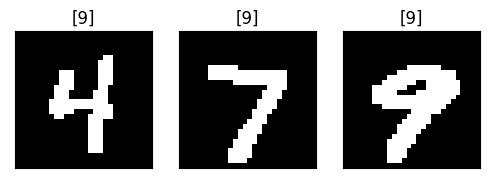

The model has achieved a score of 0.5589403973509933
The model had the following params {'priors': None, 'var_smoothing': 1e-09}


In [16]:
guassian_model = GaussianNB()
guassian_model_score, guassian_model_params = model_fit_and_score(guassian_model, X_train_binary, Y_train, X_test_binary, Y_test)
print("The model has achieved a score of", guassian_model_score)
print("The model had the following params", guassian_model_params)

Se puede ver como el resultado del modelo no es destacable, ya que ha obtenido un score de 0.559. Vemos que la binarización de los datos no significa un problema, ya que analizando brevemente el dataset, se puede como siguen existiendo diferencias destacables. Entonces, se puede decir que el problema se encuentra en el modelo elejido. Un clasificador de Naive Bayes asume que la presencia o ausencia de una característica particular no está relacionada con la presencia o ausencia de cualquier otra característica, dada la clase variable. Entonces, podemos decir que este tipo de modelo considera como independientes las características, y al tratarlas como independientes el modelo no es capaz de obtener buenos resultados.

# Apartado 3
En esta aplicación la calidad del modelo es bastante importante y es probable que las fronteras entre los dígitos sean complejas. Ajusta un modelo k nearest neighbours a la matriz original y la binarizada explorando adecuadamente los hiperparámetros de este modelo. Comenta los resultados

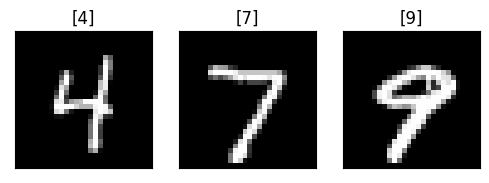

The model has achieved a score of 0.9788079470198675
The model had the following params {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [17]:
neigh = KNeighborsClassifier()
neigh_score, neigh_params = model_fit_and_score(neigh, X_train, Y_train, X_test, Y_test)
print("The model has achieved a score of", neigh_score)
print("The model had the following params", neigh_params)

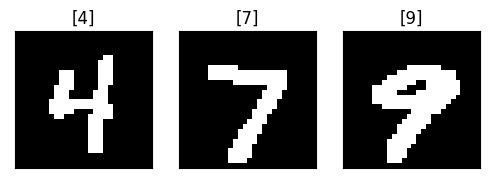

The model has achieved a score of 0.9629139072847682
The model had the following params {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [18]:
neigh = KNeighborsClassifier()
neigh_binary_score, neigh_binary_params = model_fit_and_score(neigh, X_train_binary, Y_train, X_test_binary, Y_test)
print("The model has achieved a score of", neigh_binary_score)
print("The model had the following params", neigh_binary_params)

El modelo de classificación k-nearest neighbors, es un método de clasificación no paramétrico, que estima el valor de la función de densidad de probabilidad o directamente la probabilidad a posteriori de que un elemento x pertenezca a la clase Cj a partir de la información proporcionada por el conjunto de prototipos. Por lo tanto, buscara patrones en los datos con el objetivo de poder classificar con exactitud. En este experimento, podemos concluir que la binarización de los datos no era el problema en el apartado anterior, ya que en este caso, se puede ver como las diferencias entre los datos binarizados y no binarizados es substancialmente pequeña (0.0159). 

# Apartado 4.
Habás observado al hacer el PCA que el número de componentes necesario para explicar la variancia de los datos no es muy grande respecto a su dimensionalidad real. Elige un número de componentes, obtén las matrices de datos transformadas. Ajusta un modelo Naïve Bayes y un K nearest neighbours a estos datos explorando adecuadamente sus hiperparámetros. Evalúa la calidad de los modelos. ¿Por qué sería más adecuado usar el Naïve Bayes con esta transformación? ¿Qué ventajas/inconvenientes tendría el trabajar con los datos transformados? ¿Qué modelo de entre todos elegirías para reconocer códigos postales? Razona tu respuesta.

In [22]:
binarizer = Binarizer().fit(X_train)
X_train_binary = binarizer.transform(X_train)
X_test_binary = binarizer.transform(X_test)

pca = PCA().fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.fit_transform(X_test)

pca = PCA().fit(X_train_binary)
X_train_transformed_binary = pca.transform(X_train_binary)
X_test_transformed_binary = pca.fit_transform(X_test_binary)


x = list(range(1,len(X_test_transformed)))
scores = np.zeros(shape=(4, len(x)))
execution_time = np.zeros(shape=(4, len(x)))

guassian_model = GaussianNB()
neigh = KNeighborsClassifier()

for i in tqdm(x):
    scores[0, i-1], execution_time[0, i-1] = model_fit_and_score(guassian_model, X_train_transformed[:,:i], Y_train, X_test_transformed[:,:i], Y_test, call_show_image=False, return_exec_time=True)
    scores[1, i-1], execution_time[1, i-1] = model_fit_and_score(neigh, X_train_transformed[:,:i], Y_train, X_test_transformed[:,:i], Y_test, call_show_image=False, return_exec_time=True)
    scores[2, i-1], execution_time[2, i-1] = model_fit_and_score(guassian_model, X_train_transformed_binary[:,:i], Y_train, X_test_transformed_binary[:,:i], Y_test, call_show_image=False, return_exec_time=True)
    scores[3, i-1], execution_time[3, i-1] = model_fit_and_score(neigh, X_train_transformed_binary[:,:i], Y_train, X_test_transformed_binary[:,:i], Y_test, call_show_image=False, return_exec_time=True)

100%|██████████| 754/754 [02:24<00:00,  5.22it/s]


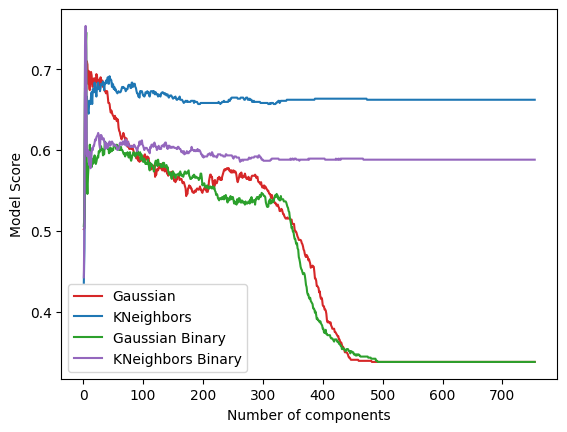

In [23]:
plt.figure()
for idx, (label, color) in enumerate(zip(["Gaussian", "KNeighbors", "Gaussian Binary", "KNeighbors Binary"], ['tab:red', 'tab:blue', 'tab:green', 'tab:purple'])):
    plt.plot(x, scores[idx, :].tolist(), color=color, label=label)
plt.legend()
plt.ylabel("Model Score")
plt.xlabel("Number of components")
plt.show()

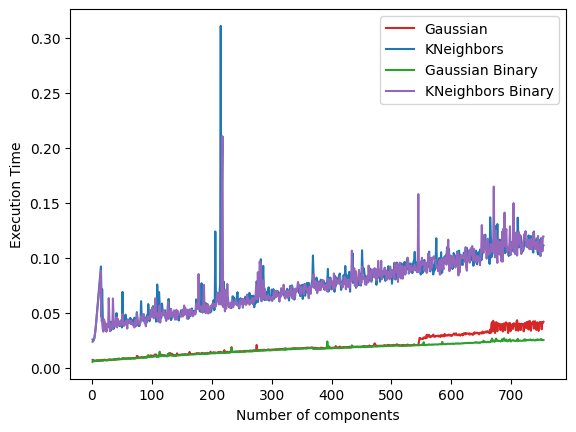

In [24]:
plt.figure()
for idx, (label, color) in enumerate(zip(["Gaussian", "KNeighbors", "Gaussian Binary", "KNeighbors Binary"], ['tab:red', 'tab:blue', 'tab:green', 'tab:purple'])):
    plt.plot(x, execution_time[idx, :].tolist(), color=color, label=label)
plt.legend()
plt.ylabel("Execution Time")
plt.xlabel("Number of components")
plt.show()

In [29]:
NUMERO_DE_COMPONENTES = 5
pca = PCA(n_components=NUMERO_DE_COMPONENTES)
X_train_100 = pca.fit_transform(X_train)
X_test_100 = pca.transform(X_test)

In [30]:
guassian_model = GaussianNB()
guassian_model, guassian_model_100_score, guassian_model_100_params = model_fit_and_score(guassian_model, X_train_100, Y_train, X_test_100, Y_test, call_show_image=False, return_model=True)
print("The model has achieved a score of", guassian_model_100_score)
print("The model had the following params", guassian_model_100_params)

The model has achieved a score of 0.8066225165562914
The model had the following params {'priors': None, 'var_smoothing': 1e-09}


In [31]:
neigh = KNeighborsClassifier()
neigh, neigh_100_score, neigh_100_params = model_fit_and_score(neigh, X_train_100, Y_train, X_test_100, Y_test, call_show_image=False, return_model=True)
print("The model has achieved a score of", neigh_100_score)
print("The model had the following params", neigh_100_params)

The model has achieved a score of 0.847682119205298
The model had the following params {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [32]:
list_of_4_test, list_of_7_test, list_of_9_test = split_list_into_diferent_y(X_test, Y_test)
iterator_list_of_4_test, iterator_list_of_7_test, iterator_list_of_9_test = iter(list_of_4_test), iter(list_of_7_test), iter(list_of_9_test)

Precition done with GaussianNB, this model had a score of 0.8066225165562914
Precition done with KNeighborsClassifier, this model had a score of 0.847682119205298
The following images titles had this struture [GaussianNb, KNeighborsClassifier] predicted values.


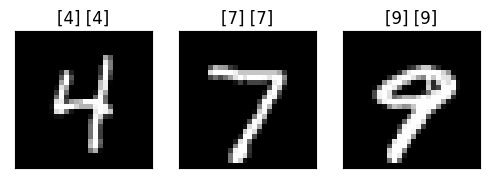

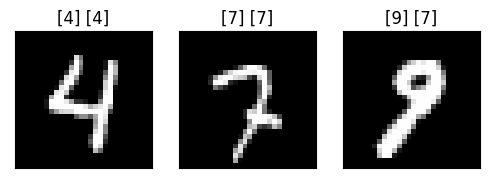

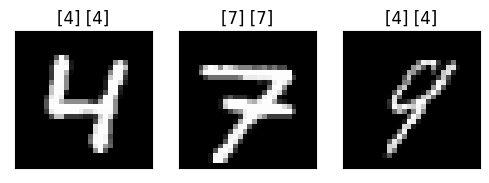

In [33]:
print("Precition done with GaussianNB, this model had a score of", guassian_model_100_score)
print("Precition done with KNeighborsClassifier, this model had a score of", neigh_100_score)
print("The following images titles had this struture [GaussianNb, KNeighborsClassifier] predicted values.")
for i in range(3):
    image_4_test, image_7_test, image_9_test = next(iterator_list_of_4_test), next(iterator_list_of_7_test), next(iterator_list_of_9_test)
    [image_4_test_transformed], [image_7_test_transformed], [image_9_test_transformed] = pca.transform([image_4_test]), pca.transform([image_7_test]), pca.transform([image_9_test])

    image_4_test_prediction_g, image_7_test_prediction_g, image_9_test_prediction_g = guassian_model.predict([image_4_test_transformed]), guassian_model.predict([image_7_test_transformed]), guassian_model.predict([image_9_test_transformed])
    image_4_test_prediction_k, image_7_test_prediction_k, image_9_test_prediction_k = neigh.predict([image_4_test_transformed]), neigh.predict([image_7_test_transformed]), neigh.predict([image_9_test_transformed])
    show_image([image_4_test, image_7_test, image_9_test], labels=[str(image_4_test_prediction_g) + ' ' + str(image_4_test_prediction_k), str(image_7_test_prediction_g) + ' ' + str(image_7_test_prediction_k), str(image_9_test_prediction_g) + ' ' + str(image_9_test_prediction_k)])

Para poder sacar las conclusiones más acertadas, se ha creido oportuno ver la evolución de los modelos a medida que se añadian componentes del PCA. Para cada aumento del PCA, se han entrenado los modelos k-nearest neighbors y clasificador de Naive Bayes, ambos con los datos binarizados y no binarizados. La diferencia de trabajar con los datos binarizados o no binarizados no es relevante en este estudio, pero podriamos resumirlo diciendo que no afecta demasiado en los resultados obtenidos, como se puede apreciar en los scores mostrados en las graficas anteriores, además, los tiempos de entrenamiento no difieren demasiado entre los datos binarizados y los no binarizados para ambos modelos. 

En el estudio se ha podido ver que el modelo de classificación Naive Bayes tiene un tiempo de entrenamiento substancialmente inferior al de k-nearest neighbors, esto se deve a que el modelo de classificación Naive Bayes es un modelo probabilistico de variables independientes. Por otra parte, el modelo k-nearest neighbors busca patrones dentro de los datos, por lo tanto su coste de entrenamiento es superior, pero nos da mejores resultados que el Naive Bayes. 

Cabe destacar, que cuando no hay muchas variables en el dataset, las diferencias entre los dos modelos se reducen, por lo tanto, si nuestro conjunto de datos tiene pocas variables es mejor escojer el Naive Bayes, ya que el coste computacional es inferior y los resultados son parecidos.